# 03 - Interactive Viz

🗺️🗺️🗺️ [LINK WITH INTERACTIVE MAPS ON NBVIEWER](https://nbviewer.jupyter.org/github/demurgos/ada-epfl/blob/master/03-Interactive_Viz/homework.ipynb) 🗺️🗺️🗺️

## Introduction 

In this Homework, we study interactive data visualizations and maps. We will work on unemployments rates accross Europe and especially Switzerland.

In [42]:
#import and constants
import folium
import os
import pandas as pd
import json
import seaborn
import numpy as np
from branca.colormap import linear
import matplotlib.pyplot as plt
%matplotlib inline
DATAPATH = "./data/"

In [43]:
folium.__version__ == '0.5.0'

True

[Link to folium documentation](https://folium.readthedocs.io/en/latest/quickstart.html#geojson-topojson-overlays)

## Question 1

We use the **Harmonised unemployment rates (%) - monthly data (ei_lmhr_m)** dataset from [EuroStat](http://ec.europa.eu/eurostat/data/database). This data directly provides us with unemployment rates.

In [44]:
eu_df = pd.read_csv(os.path.join(DATAPATH,"ei_lmhr_m.tsv"), delimiter='\t', na_values=": ")
eu_df.head()

,"unit,s_adj,indic,geo\time",2017M10,2017M09,2017M08,2017M07,2017M06,2017M05,2017M04,2017M03,2017M02,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,"PC_ACT,NSA,LM-UN-F-GT25,AT",NaN,4.1,4.8,3.7,4.5,4.7,4.3,4.9,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"PC_ACT,NSA,LM-UN-F-GT25,BE",NaN,5.9,6.3,6.3,5.9,6.0,6.5,7.2,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"PC_ACT,NSA,LM-UN-F-GT25,BG",NaN,5.0,5.0,5.0,5.0,5.3,5.8,6.5,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"PC_ACT,NSA,LM-UN-F-GT25,CY",NaN,8.9,10.4,10.7,9.9,9.2,10.0,11.9,12.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"PC_ACT,NSA,LM-UN-F-GT25,CZ",NaN,3.2,3.1,3.1,3.0,3.2,3.9,4.0,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that the first column uses comma separators instead of tabs: we fix it by isolating this column, splitting it by comma and adding it back.

In [45]:
eu_colon_sep = eu_df[[eu_df.columns[0]]]
eu_colon_sep = eu_df[eu_df.columns[0]].apply(lambda x: pd.Series([i for i in x.split(',')]))
eu_colon_sep.columns = eu_df.columns[0].split(',')
eu_df = pd.concat([eu_colon_sep, eu_df[eu_df.columns[1:]]], axis=1)
eu_df.columns = eu_df.columns.map(lambda x: x.strip())
eu_df.head()

,unit,s_adj,indic,geo\time,2017M10,2017M09,2017M08,2017M07,2017M06,2017M05,...,1983M10,1983M09,1983M08,1983M07,1983M06,1983M05,1983M04,1983M03,1983M02,1983M01
0,PC_ACT,NSA,LM-UN-F-GT25,AT,NaN,4.1,4.8,3.7,4.5,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PC_ACT,NSA,LM-UN-F-GT25,BE,NaN,5.9,6.3,6.3,5.9,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PC_ACT,NSA,LM-UN-F-GT25,BG,NaN,5.0,5.0,5.0,5.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PC_ACT,NSA,LM-UN-F-GT25,CY,NaN,8.9,10.4,10.7,9.9,9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PC_ACT,NSA,LM-UN-F-GT25,CZ,NaN,3.2,3.1,3.1,3.0,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We select the most recent column without missing values.

In [46]:
eu_df[["2017M06"]].isnull().sum()

2017M06    0
dtype: int64

We will work with the data from June 2017.

For clarity, we only keep the relevant columns: metadata and June 2017.

In [47]:
eu_df_selec = eu_df[["unit", "s_adj", "indic", "geo\\time", "2017M06"]]
eu_df_selec.head()

,unit,s_adj,indic,geo\time,2017M06
0,PC_ACT,NSA,LM-UN-F-GT25,AT,4.5
1,PC_ACT,NSA,LM-UN-F-GT25,BE,5.9
2,PC_ACT,NSA,LM-UN-F-GT25,BG,5.0
3,PC_ACT,NSA,LM-UN-F-GT25,CY,9.9
4,PC_ACT,NSA,LM-UN-F-GT25,CZ,3.0


The dataset contains multiple indicators:

In [48]:
eu_df_selec["indic"].unique()

array(['LM-UN-F-GT25', 'LM-UN-F-LE25', 'LM-UN-F-TOT', 'LM-UN-M-GT25',
       'LM-UN-M-LE25', 'LM-UN-M-TOT', 'LM-UN-T-GT25', 'LM-UN-T-LE25',
       'LM-UN-T-TOT'], dtype=object)

Here is the meaning of the different parts:

- LM: Labour Market
- UN: Unemployment
- F: Female
- M: Male
- T: Male and Female
- GT25 : > 25 years old
- LE25 : <= 25 years old
- TOT: Any age

We will work with the most complete `LM-UN-T-TOT` because we do not differentiate between sex and age.

In [49]:
eu_un_df = eu_df_selec[eu_df_selec["indic"] == "LM-UN-T-TOT"]

Just to be sure, we check that the `unit` column has a single value `PC_ACT` (probably meaning "percentage of active population").

In [50]:
eu_df_selec["unit"].unique()

array(['PC_ACT'], dtype=object)

The `s_adj` column indicates if seasonal adjustment were applied.

In [51]:
eu_df_selec["s_adj"].unique()

array(['NSA', 'SA'], dtype=object)

There are two possible values: applied (`SA`) or not applied (`NSA`). We choose to work with the adjusted values because they are intended for better comparisons. We are finally ready to simplify our data to just keep the geographic are (`geo`) and corresponding unemployment rate (`value`).

In [52]:
eu_un_t_tot = eu_un_df[["s_adj", "indic", "geo\\time", "2017M06"]]
print("SA:  " + str(len(eu_un_t_tot[eu_un_t_tot["s_adj"] == "SA" ])))
print("NSA: " + str(len(eu_un_t_tot[eu_un_t_tot["s_adj"] == "NSA"])))
eu_un_t_tot = eu_un_t_tot[eu_un_t_tot["s_adj"] == "NSA"][["geo\\time", "2017M06"]]
eu_un_t_tot.columns = ["geo", "value"]
eu_un_t_tot.head()

SA:  38
NSA: 38


,geo,value
298,AT,5.0
299,BE,6.9
300,BG,6.1
301,CY,10.4
302,CZ,2.8


The data is almost clean but there are some strings with a percentage: we quickly normalize all the values to float. All the values are now in the range `[0; 100]`.

In [53]:
def clean_values(x):
    if(type(x) == str):
        x = float(x.replace('%', ''))
    return x
    
eu_un_t_tot["value"] = eu_un_t_tot["value"].map(clean_values)
eu_un_t_tot.head()

,geo,value
298,AT,5.0
299,BE,6.9
300,BG,6.1
301,CY,10.4
302,CZ,2.8


To get an idea of the situation, we plot the distribution of the values:

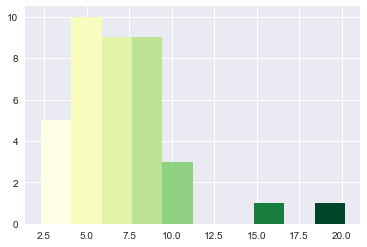

In [62]:
cm = plt.cm.get_cmap('YlGn')
n, bins, patches = plt.hist(eu_un_t_tot["value"], bins=10)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.show()

We see that most of the values are below `12.5%`. There are just two extreme points above.

The color scale used above is pretty neat: it does not rely only on hue but mostly on luminosity and saturation. It is pretty readable.

In [55]:
# Load the Europe map
eu_json_path = os.path.join(DATAPATH,"topojson","europe.topojson.json")
eu_json = json.load(open(eu_json_path))

Check the countries in our map:

In [56]:
geo_id = [country["id"] for country in eu_json['objects']['europe']['geometries']]
geo_id_df = pd.DataFrame({"id": geo_id})
geo_id_df["id"].unique()

array(['AZ', 'AL', 'AM', 'BA', 'BG', 'CY', 'DK', 'IE', 'EE', 'AT', 'CZ',
       'FI', 'FR', 'GE', 'DE', 'GR', 'HR', 'HU', 'IS', 'IL', 'IT', 'LV',
       'BY', 'LT', 'SK', 'LI', 'MK', 'MT', 'BE', 'FO', 'AD', 'LU', 'MC',
       'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'MD', 'SI', 'ES', 'SE', 'CH',
       'TR', 'GB', 'UA', 'SM', 'RS', 'VA', 'RU'], dtype=object)

We can do a perfect match between the ids of the geometry and our unemployment dataset.

In [57]:
all_match = eu_un_t_tot[["geo"]].merge(geo_id_df, left_on="geo", right_on="id", how="outer")
all_match

,geo,id
0,AT,AT
1,BE,BE
2,BG,BG
3,CY,CY
4,CZ,CZ
5,DE,DE
6,DK,DK
7,EA,NaN
8,EA18,NaN
9,EA19,NaN


In the following part, we keep normalize the country codes (there was a problem with `UK` and `GB` both reffering to the same country, one in the dataset, one in the geometry).
We also remove the countries without any data from our geometry.

In [58]:
def convert_country_id(id):
    dictionnary = {
        "UK": "GB",
    }
    
    if id in dictionnary:
        return dictionnary[id]
    
    return id
    
eu_un_t_tot["geo"] = eu_un_t_tot["geo"].map(convert_country_id)
# Update the matches
all_match = eu_un_t_tot[["geo"]].merge(geo_id_df, left_on="geo", right_on="id", how="outer")

In [65]:
remove = all_match[all_match["geo"].isnull()]["id"].tolist()
countries = []
for country in eu_json['objects']['europe']['geometries']:
    if country["id"] in remove:
        continue
    countries.append(country)
eu_json['objects']['europe']['geometries'] = countries

For the scale, we will use what we learned from the distribution: there are two extreme points above `12%` and most of the data is in the range below. To create our categories, we will treat any value above `12%` as extreme. For the main values, we will use a linear scale to allow better comparisons.

In [88]:
def get_scale():
    return [0, 3, 6, 9, 12, 25]

In [89]:
m_eu = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=4)

m_eu.choropleth(geo_data=eu_json, name="Country", data=eu_un_t_tot, columns=["geo", "value"],
             key_on='feature.id', fill_color='YlGn', threshold_scale=get_scale(),
             fill_opacity=0.8, line_opacity=0.4,
             legend_name='Unemployment Rate (%)', topojson='objects.europe')
folium.LayerControl().add_to(m_eu)
m_eu

## Question 2

We start by loading the map of the cantons.

In [84]:
# First let's check the topojson file
canton_json_path = os.path.join(DATAPATH,"topojson","ch-cantons.topojson.json")
canton_json_data = json.load(open(canton_json_path))
print(canton_json_data['objects']['cantons']['geometries'])

[{'type': 'Polygon', 'arcs': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], 'id': 'ZH', 'properties': {'name': 'Zürich'}}, {'type': 'MultiPolygon', 'arcs': [[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23], [24]], [[25, 26]], [[27]], [[28, 29]]], 'id': 'BE', 'properties': {'name': 'Bern/Berne'}}, {'type': 'Polygon', 'arcs': [[-12, 30, 31, 32, 33, 34]], 'id': 'LU', 'properties': {'name': 'Luzern'}}, {'type': 'Polygon', 'arcs': [[35, 36, 37, 38, -16, 39, 40, 41]], 'id': 'UR', 'properties': {'name': 'Uri'}}, {'type': 'Polygon', 'arcs': [[42, -33, 43, -1, 44, 45, 46, -42]], 'id': 'SZ', 'properties': {'name': 'Schwyz'}}, {'type': 'MultiPolygon', 'arcs': [[[-13, -35, 47]], [[-15, 48, -40]]], 'id': 'OW', 'properties': {'name': 'Obwalden'}}, {'type': 'Polygon', 'arcs': [[-34, -43, -41, -49, -14, -48]], 'id': 'NW', 'properties': {'name': 'Nidwalden'}}, {'type': 'Polygon', 'arcs': [[49, -36, -47, 50, 51]], 'id': 'GL', 'properties': {'name': 'Glarus'}}, {'type': 'Polygon', 'arcs': [[-32, 52, -2, -4

To get the csv file, we went on the amstat website and then into Details. We chose "Chômeurs et demandeurs d'emploi", "taux de chômage" and export a csv file containing the unemployment ratio, the figures linked to unemployed people (we also add the young and long-term ones), we also select "Demandeurs d'emplois" (people looking for a job) and "Demandeurs d'emplois non chômeurs" (people with a job looking for a new one), we chose to get the stats for september 2017
Because we get the file manually, we also make the choice to clean it a bit manually before loading it.
Basically we removed the duplicates columns, which were supposed to be the total for each firsts columns.
We also removed the first row which was there to precise if the column was a total or not, we just copied the first cell "Cantons" to the second row so that we can associate it with the first column.

In [85]:
# Then let's import the csv file 
# Note that well implemented websites should also work under firefox. To be easier I've set the data in git
swiss_df = pd.read_csv(os.path.join(DATAPATH,"chomage_suisse.csv")) # TODO, load and clean
swiss_df.head()

,Cantons,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Zurich,3.3,A,27225,3420,4753,34156,6931
1,Berne,2.4,A,13658,2003,2336,18385,4727
2,Lucerne,1.7,A,3885,664,453,6756,2871
3,Uri,0.6,C,112,15,13,257,145
4,Schwyz,1.7,A,1455,185,189,2229,774


We can notice some differences between the canton's names in both sides.

In [86]:
json_swiss_names = [(i['id'],i['properties']['name']) for i in canton_json_data['objects']['cantons']['geometries']]
for (json_val,df_val) in zip(json_swiss_names,swiss_df['Cantons']):
    print(json_val,df_val)

print('Json length : {} , csv length : {}'.format(len(json_swiss_names),swiss_df.shape[0]))

('ZH', 'Zürich') Zurich
('BE', 'Bern/Berne') Berne
('LU', 'Luzern') Lucerne
('UR', 'Uri') Uri
('SZ', 'Schwyz') Schwyz
('OW', 'Obwalden') Obwald
('NW', 'Nidwalden') Nidwald
('GL', 'Glarus') Glaris
('ZG', 'Zug') Zoug
('FR', 'Fribourg') Fribourg
('SO', 'Solothurn') Soleure
('BS', 'Basel-Stadt') Bâle-Ville
('BL', 'Basel-Landschaft') Bâle-Campagne
('SH', 'Schaffhausen') Schaffhouse
('AR', 'Appenzell Ausserrhoden') Appenzell Rhodes-Extérieures
('AI', 'Appenzell Innerrhoden') Appenzell Rhodes-Intérieures
('SG', 'St. Gallen') St-Gall
('GR', 'Graubünden/Grigioni') Grisons
('AG', 'Aargau') Argovie
('TG', 'Thurgau') Thurgovie
('TI', 'Ticino') Tessin
('VD', 'Vaud') Vaud
('VS', 'Valais/Wallis') Valais
('NE', 'Neuchâtel') Neuchâtel
('GE', 'Genève') Genève
('JU', 'Jura') Jura
Json length : 26 , csv length : 27


Luckily the tuple Id,name in json match perfectly with the dataFrame, excepting the `Total` row that is useless here. 
We will just add the ID property to our dataframe without any treatment (it's already matching) and remove the last row

In [87]:
#Note that we could have reused previous variable but we have chosen to recompute it for clarity
cantons_ids = [i['id'] for i in canton_json_data['objects']['cantons']['geometries']]
if swiss_df.shape[0]>26:#We add this condition to avoid any error when running the cell twice
    no_tot_swiss_df = swiss_df.drop(26)#We remove the Total row
no_tot_swiss_df = no_tot_swiss_df.assign(canton_id=cantons_ids)

Now we will show these data on the swiss map. 
We will first show the swiss Map without our overlay and then create it. 
We chose to center with some coordinates that seemed weel suited for our visualization 

In [88]:
#TODO : Change tiles property
m_switzerland = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)
m_switzerland

We will first show the map with an overlay which show the ratio of **unemployed people** over the active population. This ratio is the one given in the data we have chosen, it is different from the ratio of people looking for a job over the active population. 
To be sure of what is represented by the ratio we have looked over the documentation and we found [here](https://www.amstat.ch/v2/definition.jsp?lang=fr) the definition of the ratio : "Nombre de chômeurs inscrits au jour de référence (dernier jour du mois) divisé par le nombre de personnes actives, multiplié par 100" (Number of unemployed people on the reference day divided by the number of active people, times 100). We have also checked that the raio in our document is really equal to the number of unemployed people over the active population. 

In [89]:
#First let's check that our ratio is the good one
# We will use the figure given in the documentation for active population
print(swiss_df['Taux de chômage'][26]-100*swiss_df['Chômeurs inscrits'][26]/4493249)
m_switzerland.choropleth(geo_data = canton_json_data,name="Cantons",data=no_tot_swiss_df,columns=['canton_id', "Taux de chômage"],
             key_on='feature.id',fill_color='YlGn', fill_opacity=0.8, line_opacity=0.2,
             legend_name='Unemployment Rate (%)',topojson='objects.cantons')
folium.LayerControl().add_to(m_switzerland)
m_switzerland


0.0362425941674


In order to add some interactivity and add more information to the map, we add a popup for each canton when it is clicked. 
Using geoJSON it would have been easy because each canton is defined indepandantly. 
However when using topoJSON it is slightly harder because each arc is defined at the beginning of the file.
We tried to reconstruct a topojson object containing all the arcs and the necessary properties for each canton, however it was really slow on the map, expecially when zooming. This is because there are many arcs and folium is probably not optimized to link 30 big topojson files to the same map. 
We decided to reconstruct a topoJSON object for each canton but keeping only the arcs that are useful for this canton. 

In [90]:
import copy
#First define a classic map
m_topo = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)
#Then manually create our colormap, as it won't be handled by the function
colormap = linear.YlGn.scale(
    no_tot_swiss_df['Taux de chômage'].min(),
    no_tot_swiss_df['Taux de chômage'].max())
#Define a dictionnary to access the value by the canton id, it's easier to get the good color with this
if 'canton_id' in no_tot_swiss_df.columns:
    no_tot_swiss_df_id = no_tot_swiss_df.set_index('canton_id')
    swiss_df_dict_taux = no_tot_swiss_df_id['Taux de chômage']
    
#From the original arcs, we recompute all the coordinates of the points (we chose to compute the real coordinates,
#not the relatives ones)
def getRelativesArcs(topo):
    relative_topo=copy.deepcopy(topo['arcs'])
    scale_lat = topo['transform']['scale'][0]
    scale_long = topo['transform']['scale'][1]
    tr_la= topo['transform']['translate'][0]
    tr_lo= topo['transform']['translate'][1]
    for f_list_n,f_list in enumerate(topo['arcs']):
        lat = 0
        long = 0
        for s_list_n,s_list in enumerate(f_list):
            lat+= s_list[0]
            long+= s_list[1]
            relative_topo[f_list_n][s_list_n]=[lat*scale_lat+tr_la,long*scale_long+tr_lo]
    return relative_topo
#Add a list of complete coordinates to our new list of arcs with the topojson format
def addArcToList(init_list,old_coord):
    temp_list=[]
    sum_lat = 0
    sum_long = 0
    for arcs in old_coord:
        new_lat=arcs[0]
        new_long=arcs[1]
        temp_list.append([new_lat-sum_lat,new_long-sum_long])
        sum_lat=new_lat
        sum_long=new_long
    init_list.append(temp_list)
# Run over all the arcs used in a canton, get the original arc which is corresponding
# Then compute the new version and change the index in the canton to match our new list
def keepArcs(geometry,relative_arcs):
    new_list=[]
    for f_list_n,f_list in enumerate(geometry['arcs']):
        #this is not really reusable but it fits well for our case
        for s_list_n,s_list in enumerate(f_list):
            if type(s_list)==list:
                for t_list_n,t_list in enumerate(s_list):
                    if type(t_list)==list:
                        print("Error ! ")
                    if t_list >= 0:
                        addArcToList(new_list,relative_arcs[t_list])
                    else:
                        #in topojson a negative index means we should take the reversed corresponding arc
                        #where corresponding arc is found by using a bitwise not
                        addArcToList(new_list,relative_arcs[~t_list][::-1])
                    geometry['arcs'][f_list_n][s_list_n][t_list_n]=len(new_list)-1
            else:
                if s_list >= 0:
                        addArcToList(new_list,relative_arcs[s_list])
                else:
                        addArcToList(new_list,relative_arcs[~s_list][::-1])
                geometry['arcs'][f_list_n][s_list_n]=len(new_list)-1
    return new_list
#Create a new feature (topojson object) for a canton
def getFeatures(topo,key,geometry,relative_arcs):
    iterator_topo = {}
    iterator_topo['arcs']=keepArcs(geometry,relative_arcs)
    iterator_topo['type'] = topo['type']
    #As we use complete coordinates, we do not need to scale nor translate
    iterator_topo['transform'] = {"scale":[1,1],"translate":[0,0]}
    temp_cantons= {"type":topo['objects'][key]['type']}
    temp_cantons['geometries']=[geometry]
    iterator_topo['objects'] = {key : temp_cantons}
    return iterator_topo

rel_arcs = getRelativesArcs(canton_json_data)

for i in canton_json_data["objects"]["cantons"]["geometries"]:
    full_data_row = no_tot_swiss_df_id.loc[i['id']]
    feature = getFeatures(canton_json_data,"cantons",copy.deepcopy(i),rel_arcs)
    info_string = f"<b>{full_data_row['Cantons']} </b>\
    </br>Unemployment ratio : {full_data_row['Taux de chômage']} %\
    </br>Variation coefficient : {full_data_row['Coefficients de variation']}\
   </br>Number of unemployed people : {full_data_row['Chômeurs inscrits']}"
    folium.TopoJson(
        feature,
        object_path="objects.cantons",
        style_function=lambda f: {
            'fillColor': colormap(swiss_df_dict_taux[f['id']]),
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5',
            'fillOpacity': 0.9,
        },        
    ).add_child(folium.Popup(info_string)).add_to(m_topo)
m_topo


We will know create a new column which represents the rates of unemployment without the people who already have a job.
In our csv file we have differents columns : "Chômeurs inscrits" are people who does not have a job, "Chômeurs jeunes" are young people without a job,"Chômeurs de longue durée" are people without a job for a long period of time (to be precise, over one year : [source](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosigkeit/Langzeitarbeitslosigkeit.html)), "Demandeurs d'emploi" are all people looking for a job including "Demandeurs d'emploi non chômeurs" which are people looking for a job while having another one. Column "Chômeurs inscrits" is the same as the difference "Demandeurs d'emploi" minus "Demandeurs d'emploi non chômeurs".

Let's add a column which reprensents the percentage of people looking for a job while already have one over all the people looking for a job

In [91]:
if swiss_df["Demandeurs d'emploi"].dtype == str and swiss_df["Demandeurs d'emploi non chômeurs"].dtype == str:
    swiss_df["Demandeurs d'emploi non chômeurs"] = swiss_df["Demandeurs d'emploi non chômeurs"].apply(lambda row : "".join(row.split()))
    swiss_df["Demandeurs d'emploi"] = swiss_df["Demandeurs d'emploi"].apply(lambda row : "".join(row.split()))

In [92]:
#TODO : convert to float before ? 
swiss_df["Demandeurs d'emploi non chômeurs"] = pd.to_numeric(swiss_df["Demandeurs d'emploi non chômeurs"])
swiss_df["Demandeurs d'emploi"] = pd.to_numeric(swiss_df["Demandeurs d'emploi"])
swiss_df['percent_working'] =swiss_df["Demandeurs d'emploi non chômeurs"]/ swiss_df["Demandeurs d'emploi"] *100
swiss_df['percent_working']

0     20.292189
1     25.711178
2     42.495560
3     56.420233
4     34.724092
5     52.037618
6     43.119266
7     41.654979
8     40.994264
9     43.013908
10    42.652384
11    33.146285
12    26.317690
13    44.759450
14    39.607390
15    39.215686
16    40.876194
17    54.980695
18    29.455266
19    45.567818
20    40.034582
21    30.402856
22    40.002492
23    25.385827
24    21.055688
25    31.831579
26    31.222886
Name: percent_working, dtype: float64

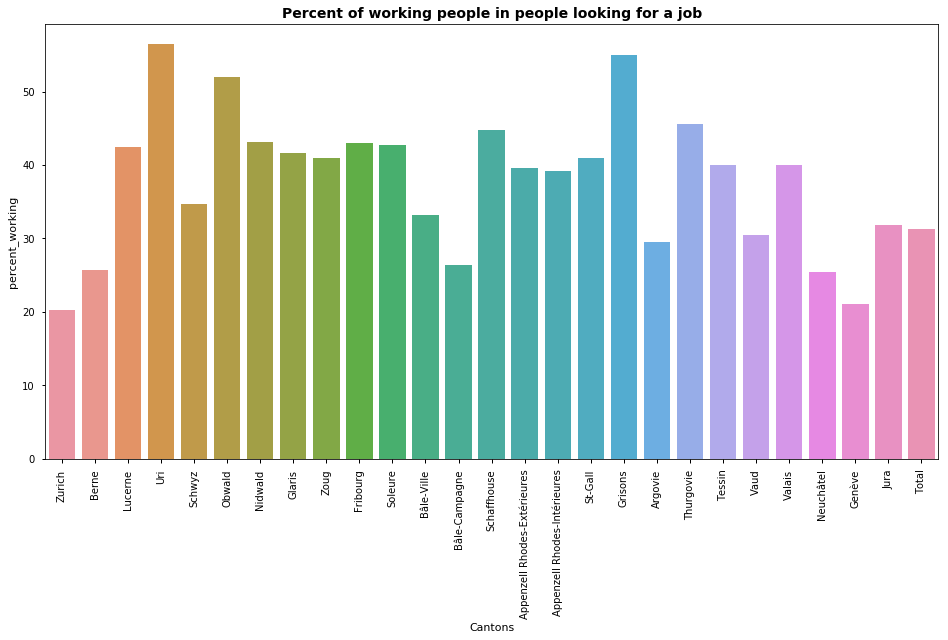

In [93]:
seaborn.set_palette("Set1")
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
result = seaborn.barplot(swiss_df["Cantons"], swiss_df["percent_working"], ax=axes)
result.set_xticklabels(swiss_df["Cantons"], rotation=90)
result.set_title("Percent of working people in people looking for a job", fontsize=14, fontweight="bold")

The percentage is really high, especially for some cantons with more than 50% of people looking for a job already have one.
Now let's build our new percentage : 

In [94]:
no_tot_swiss_df['Looking job ratio']=no_tot_swiss_df['Demandeurs d\'emploi']*no_tot_swiss_df['Taux de chômage']/no_tot_swiss_df['Chômeurs inscrits']
no_tot_swiss_df

,Cantons,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,canton_id,Looking job ratio
0,Zurich,3.3,A,27225,3420,4753,34156,6931,ZH,4.140121
1,Berne,2.4,A,13658,2003,2336,18385,4727,BE,3.230634
2,Lucerne,1.7,A,3885,664,453,6756,2871,LU,2.956293
3,Uri,0.6,C,112,15,13,257,145,UR,1.376786
4,Schwyz,1.7,A,1455,185,189,2229,774,SZ,2.604330
5,Obwald,0.7,B,153,21,10,319,166,OW,1.459477
6,Nidwald,1.0,B,248,31,24,436,188,NW,1.758065
7,Glaris,1.8,B,416,60,78,713,297,GL,3.085096
8,Zoug,2.3,B,1543,133,248,2615,1072,ZG,3.897926
9,Fribourg,2.7,A,4466,683,486,7837,3371,FR,4.737998


This time we will use TopoJSON function in order to keep the same colormap for both ratio

In [95]:
colormap = linear.YlGn.scale(
    no_tot_swiss_df['Taux de chômage'].min(),
    no_tot_swiss_df['Looking job ratio'].max())

if 'canton_id' in no_tot_swiss_df.columns:
    no_tot_swiss_df_id = no_tot_swiss_df.set_index('canton_id')
    
swiss_df_dict_taux = no_tot_swiss_df_id['Taux de chômage']
swiss_df_dict_job_ratio = no_tot_swiss_df_id['Looking job ratio']
    
m_switzerland_both = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)

folium.TopoJson(
    canton_json_data,
    name="Only unemployed",
    object_path="objects.cantons",
    style_function=lambda f: {
        'fillColor': colormap(swiss_df_dict_taux[f['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },        
).add_to(m_switzerland_both)
folium.TopoJson(
    canton_json_data,
    name="Looking for a job",
    object_path="objects.cantons",
    style_function=lambda f: {
        'fillColor': colormap(swiss_df_dict_job_ratio[f['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },        
).add_to(m_switzerland_both)
folium.LayerControl().add_to(m_switzerland_both)
m_switzerland_both

In [96]:
m_switzerland_both = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)

m_switzerland_both.choropleth(geo_data = canton_json_data,name="Only unemployed",data=no_tot_swiss_df,columns=['canton_id', "Taux de chômage"],
             key_on='feature.id',fill_color='YlGn', fill_opacity=0.8, line_opacity=0.2,
             legend_name='Unemployment Rate (%)',topojson='objects.cantons')
m_switzerland_both.choropleth(geo_data = canton_json_data,name="Looking for a job",data=no_tot_swiss_df,columns=['canton_id', "Looking job ratio"],
             key_on='feature.id',fill_color='YlGn', fill_opacity=0.8, line_opacity=0.2,
             legend_name='Unemployment Rate (%)',topojson='objects.cantons')
folium.LayerControl().add_to(m_switzerland_both)
m_switzerland_both

TODO : analysis of result

TODO : add something else to the map?

## Question 3



Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.


In [97]:
# Idea for showing multiple data
import vincent
vincent.core.initialize_notebook()
#TODO get a full dict canton -> coordinates 
capital_coordinates ={"VD":(46.519962, 6.633597)}
#Vincent does not like np orginal format
test_list = [int(no_tot_swiss_df_id.loc['VD']['Chômeurs de longue durée']),int(no_tot_swiss_df_id.loc['VD']['Chômeurs jeunes'])]

m_marker = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)
folium.Marker(capital_coordinates["VD"], popup=folium.Popup(max_width=450).add_child(
        folium.Vega(vincent.Bar(test_list,width=300,height=250).to_json(),width=300,height=250))).add_to(m_marker)
m_marker


#Other idea : set the marker with the color of another data

In [98]:
test_list = [int(no_tot_swiss_df_id.loc['VD']['Chômeurs de longue durée']),int(no_tot_swiss_df_id.loc['VD']['Chômeurs jeunes'])]
vincent.Bar(test_list,width=300,height=250)

In [99]:
js=v.to_json

NameError: name 'v' is not defined

## Question 4

using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

'/home/lemni/Documents/cours/appliedDataAnalysis/git/ada-epfl'

'/home/lemni/Documents/cours/appliedDataAnalysis/git/ada-epfl'